In [23]:
import torch
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from diffusers import AutoPipelineForImage2Image, UNet2DConditionModel, LCMScheduler
from diffusers.utils import make_image_grid, load_image, export_to_video

In [2]:
def zoom_out(image, mask_width=10):
    resized_image = image.resize((image.height - 2 * mask_width, image.width - 2 * mask_width))
    blank = np.zeros_like(image)
    blank[mask_width:-mask_width, mask_width:-mask_width] = resized_image
    resized_image = Image.fromarray(blank)
    
    mask = np.ones_like(image) * 255
    mask[mask_width:-mask_width, mask_width:-mask_width] = 0
    return resized_image.convert('RGB'), Image.fromarray(mask)

def rotate(image, angle=10):
    rotated_image = image.rotate(angle, expand=False)
    mask = Image.fromarray(np.ones_like(frames[0]) * 255)
    mask = mask.rotate(10, expand=False)
    mask = Image.fromarray(255 - np.array(mask))
    return rotated_image.convert('RGB'), mask

def move(image, width, direction):
    temp = np.array(image)
    mask = np.zeros_like(temp)
    if direction == 'top':
        temp = np.pad(temp, ((width, 0), (0, 0), (0, 0)))
        temp = temp[:image.height]
        mask[:width] = 255
    elif direction == 'bottom':
        temp = np.pad(temp, ((0, width), (0, 0), (0, 0)))
        temp = temp[-image.height:]
        mask[-width:] = 255
    elif direction == 'left':
        temp = np.pad(temp, ((0, 0), (width, 0), (0, 0)))
        temp = temp[:, :image.width]
        mask[:, :width] = 255
    elif direction == 'right':
        temp = np.pad(temp, ((0, 0), (0, width), (0, 0)))
        temp = temp[:, -image.width:]
        mask[:, -width:] = 255
    return Image.fromarray(temp).convert('RGB'), Image.fromarray(mask)

def inpaint(image, mask):
    img = np.array(curr)
    msk = np.array(mask)[..., 0]
    img = cv2.inpaint(img, msk, 3, cv2.INPAINT_NS)
    return Image.fromarray(img)

In [3]:
import torch
from diffusers import AutoPipelineForImage2Image, UNet2DConditionModel, LCMScheduler
from diffusers.utils import load_image

unet = UNet2DConditionModel.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7",
    subfolder="unet",
    torch_dtype=torch.float16,
)

pipe = AutoPipelineForImage2Image.from_pretrained(
    "Lykon/dreamshaper-7",
    unet=unet,
    torch_dtype=torch.float16,
    variant="fp16",
    safety_check=None
).to("cuda")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/soroush/.venv/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [4]:
pipe.enable_xformers_memory_efficient_attention()
pipe.set_progress_bar_config(disable=True)

In [34]:
torch.cuda.empty_cache()

duration = 6
fps = 15
n = duration * fps
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
frames = [init_image]
generator = torch.Generator("cuda").manual_seed(7)

for i in tqdm(range(n)):
    # direction = ['left', 'top', 'right', 'bottom'][i * 4 // n]
    # curr, mask = move(frames[-1], 5, direction=direction)
    curr, mask = zoom_out(frames[-1], 10)
    curr = inpaint(curr, mask)
    prompt='a realistic photo of a mountain in the middle of a bright and green forest in a sunny day, high quality, 4k'
    negative_prompt = 'blurry, fuzzy, low quality, unstable, poor details, dark, gloomy'
    frames += pipe(
        prompt,
        negative_prompt=negative_prompt,
        image=curr,
        num_inference_steps=5,
        guidance_scale=7.,
        strength=0.5,
        generator=generator
    ).images

  0%|          | 0/96 [00:00<?, ?it/s]

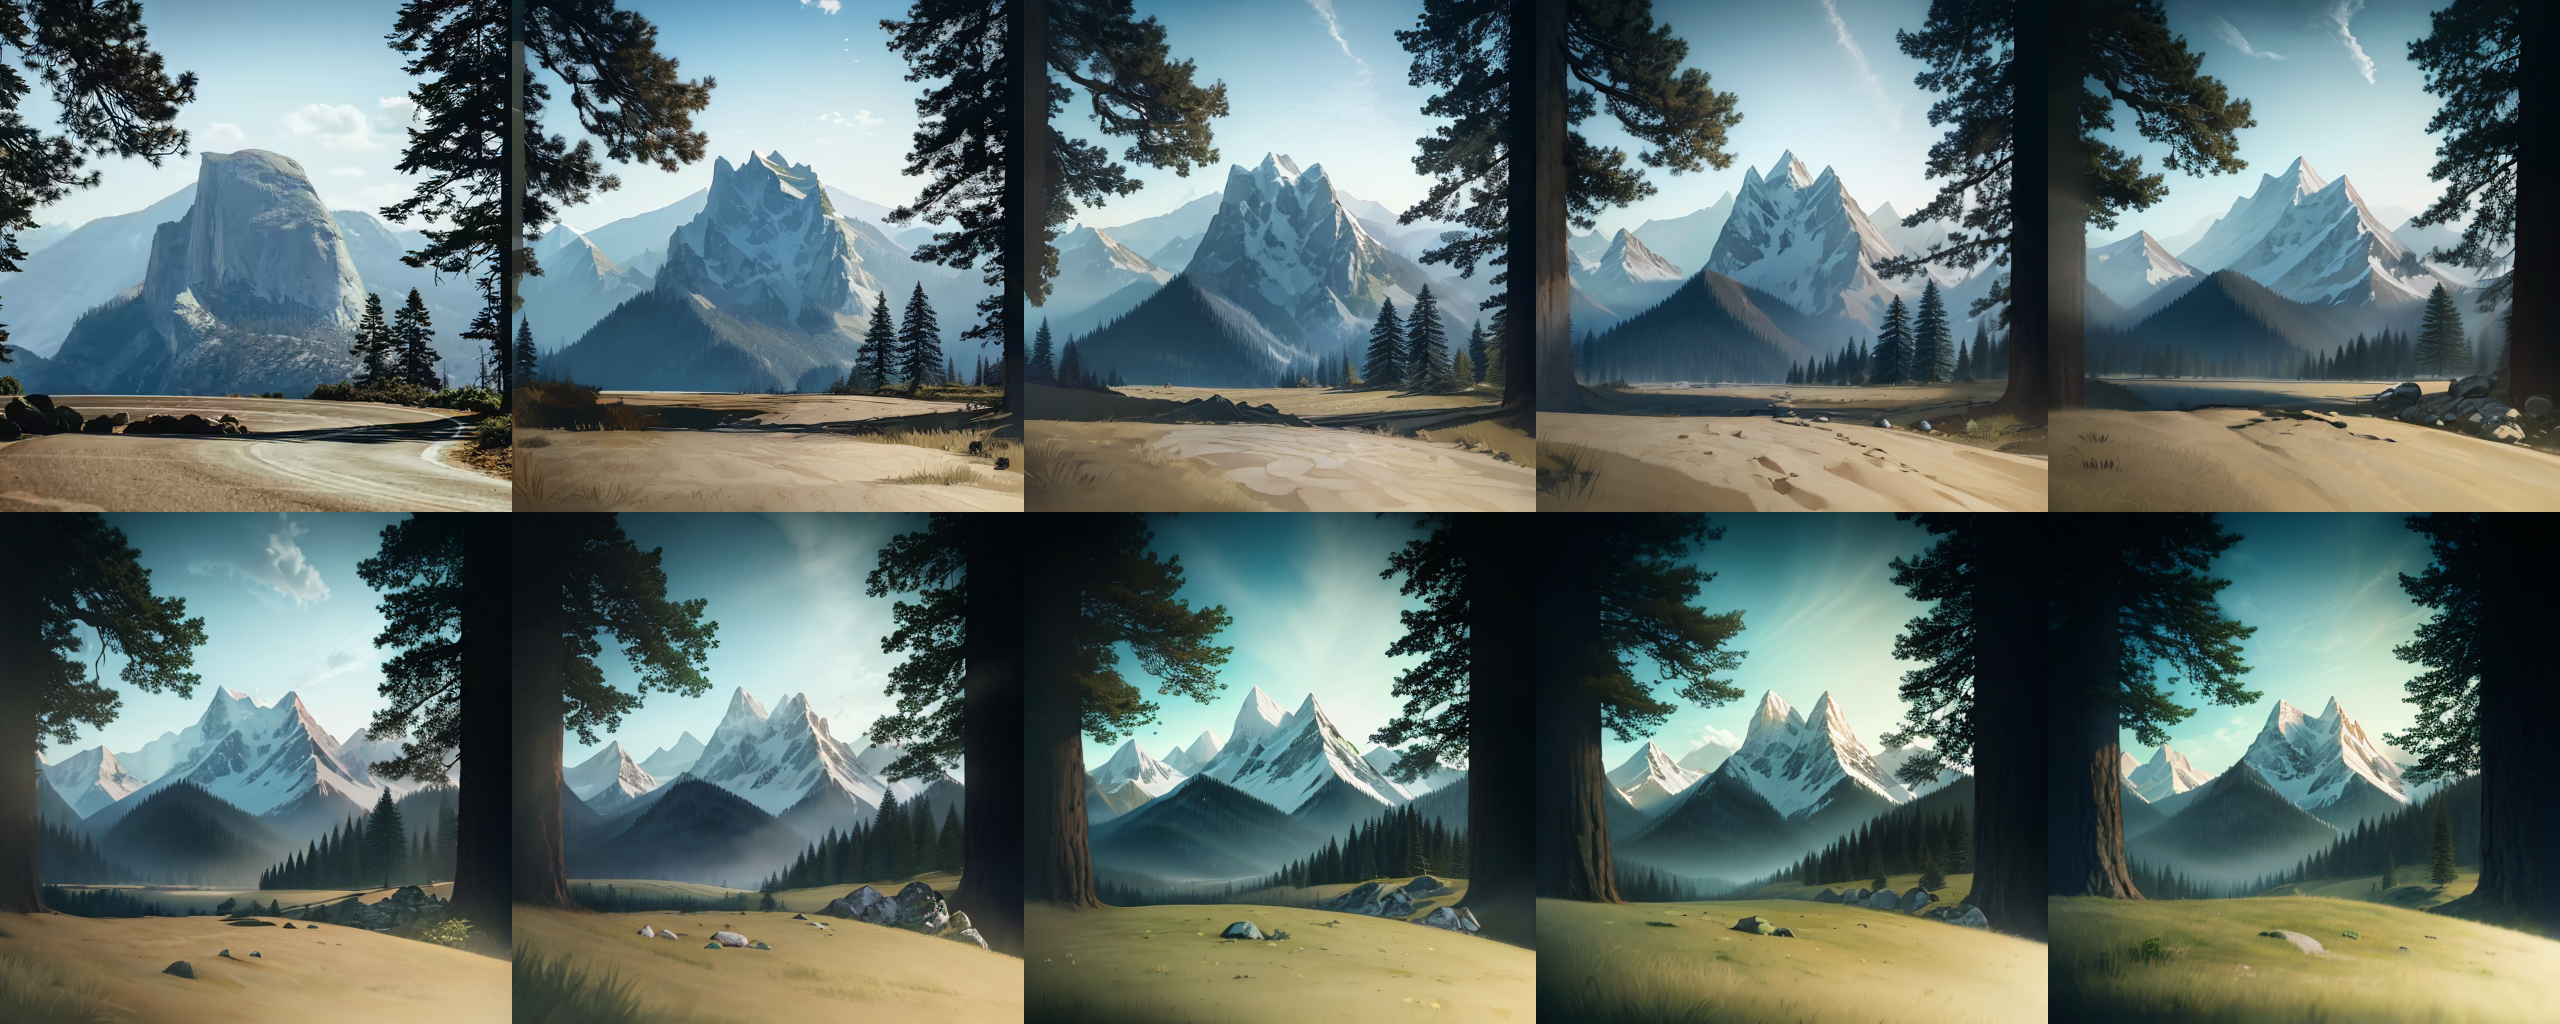

In [35]:
make_image_grid(frames[:10], rows=2, cols=5)

In [36]:
export_to_video(frames[::-1], "zoom.mp4")

'zoom.mp4'